<a href="https://colab.research.google.com/github/laszloferenczi/InfineonDigileanTechDay2024/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Off FutureWarnings
import warnings
warnings.filterwarnings('ignore')

#Resampling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

# Save model
import pickle

In [47]:
## Upload df
df = pd.read_csv(r'predictive_maintenance.csv')
pd.options.mode.chained_assignment = None
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [48]:
# Verify if the data has duplicate values
data_duplicates = df.duplicated().sum()
print("Total duplicated values: ", data_duplicates)


Total duplicated values:  0


There are not duplicate values, so we don’t need remove any row.

In [49]:
# Verify if the data has missing values
data_null = df.isnull().sum().sum()
print("Total missing values: ", data_null)

Total missing values:  0


There are not missing values, so we don’t need apply some strategic to deal with this, like SimpleImputer that deal with numeric and categoric columns.

In [50]:
## Verify the data structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


There aren’t null values in the columns and that the their type is correct.

In [51]:
## Numeric features analysis
df.describe()


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In the columns “Rotational speed”, “Torque” and “Tool wear” may have outliers values.
So we’ll analyse better this in the next steps and conclude if there are outiliers and as to proceed with this values.

In [52]:
## Verify the proportion of column "Target"
df.Target.value_counts()


,count
Target,
0,9661
1,339


The dataset has unbalanced classes in this columns, 95% of this dataset is classified without failure. In the next steps will be necessary analyse as proceed with this.

In [53]:
## Verify the proportion of column "Failure_type"
df [ 'Failure Type' ].value_counts()


,count
Failure Type,
No Failure,9652
Heat Dissipation Failure,112
Power Failure,95
Overstrain Failure,78
Tool Wear Failure,45
Random Failures,18


Don't have proportion in the column “Failure_type” distribution, because of that will be necessary apply any strategic to deal with this to previne the model to has overfitting or that any random palpite to classify the failure class perform better than any model like DummyClassifier.

In [54]:
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'
}
df.rename(rename_columns, axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   Product_ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air_temperature      10000 non-null  float64
 4   Process_temperature  10000 non-null  float64
 5   Rotational_speed     10000 non-null  int64  
 6   Torque               10000 non-null  float64
 7   Tool_wear            10000 non-null  int64  
 8   Target               10000 non-null  int64  
 9   Failure_type         10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [55]:
# Analysing redundance value, count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Number of failures:', count_failures)

# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Sum of failures different of "No Failure":', sum_failures)


Number of failures: 339
Sum of failures different of "No Failure": 330


There are 9 ambiguos values, so we need remove this.

In [56]:
# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]
# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)



In [57]:
#Removing unnecessary columnds
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)



Dont have a significant quantity of this class to try predict when it happen, so if we dont remove this now, we can have problems relacioned a big imbalanced classes. As us objetive is classfy the type of failure and apply the concepts of data science, i will remove this.

In [58]:
# Removing "Random Failures" of the "Failure_type" column.
df = df.loc[df['Failure_type'] != 'Random Failures']

In [59]:
## Renaming the classes
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}
df['Type'].replace(rename_type, inplace = True)

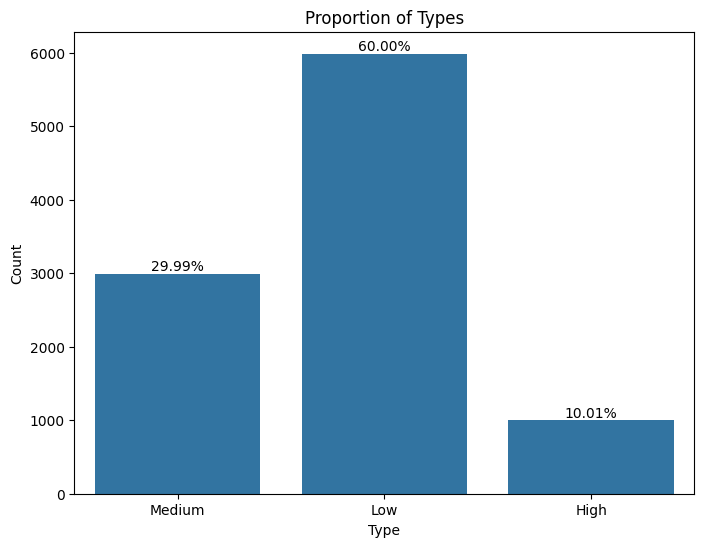

In [61]:
# Count types
tip = df['Type'].value_counts()

# Show graphic
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

# Add as percentages as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

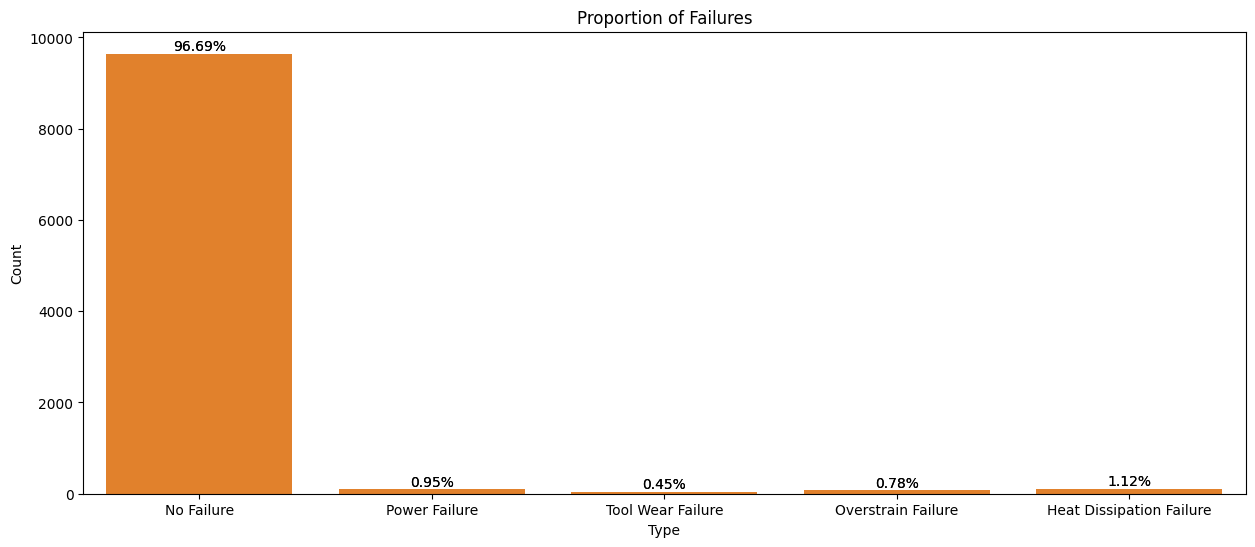

In [62]:
# Count types
tip = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')
ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

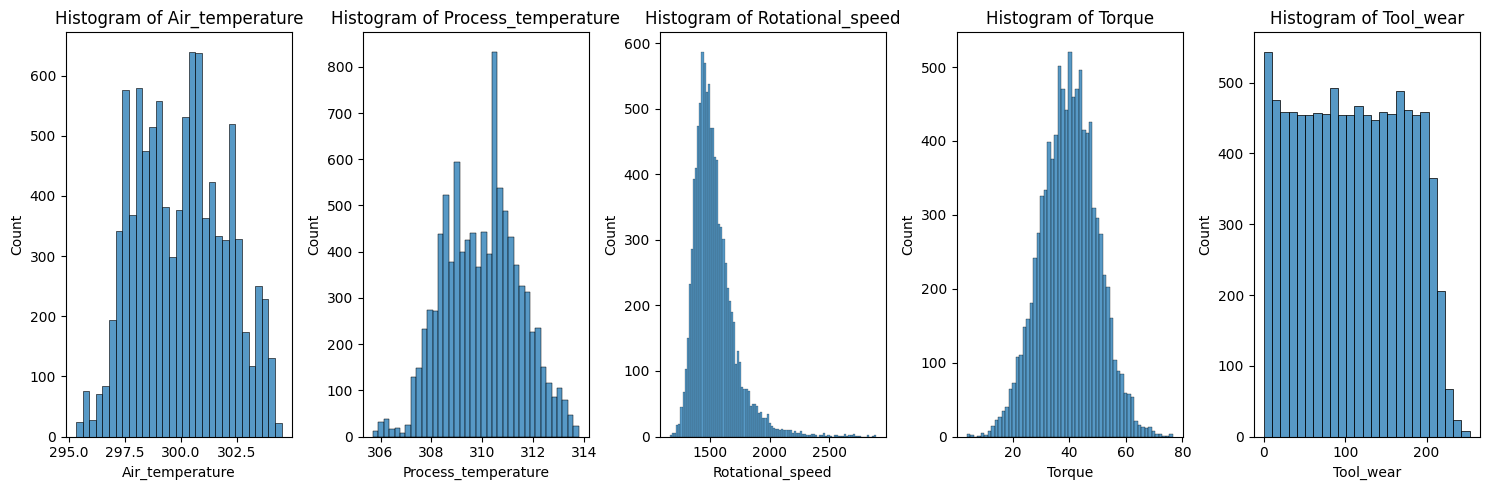

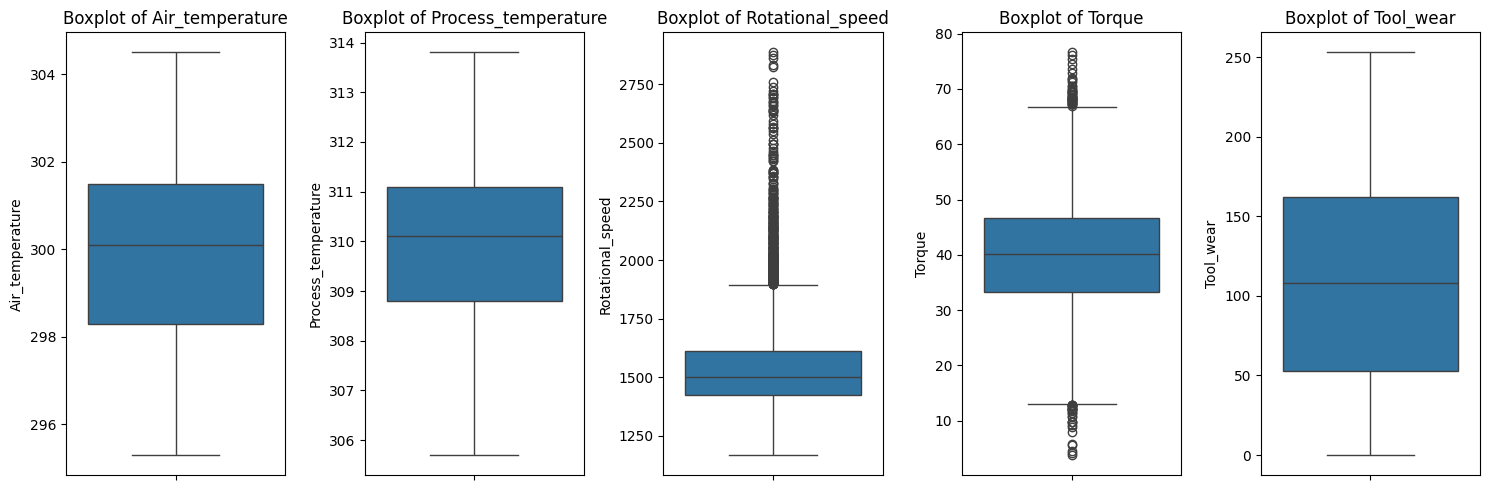

In [63]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')

# Adjust subplot
plt.tight_layout()

# Show histogram
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()


With respect to histogram, the columns Air_temperatura, Process_temperature and torque is similar to normal distribution and rotation_speed is assimetric with negative bias. Regarding to boxplot, here it’s possible confirm the hypothesis that exist outliers is some columns as soon as mencioned in the begging of this project. However, we won’t remove this values because make sense that when a machine have one type of failure the values measurement by some sensor will increase so much. Furthermore, when the rotarional_speed increase a lot make totally sense that torque decrease too, this is a physics behavior, so the outliers detected in torque column with low values possibility is caused by this.

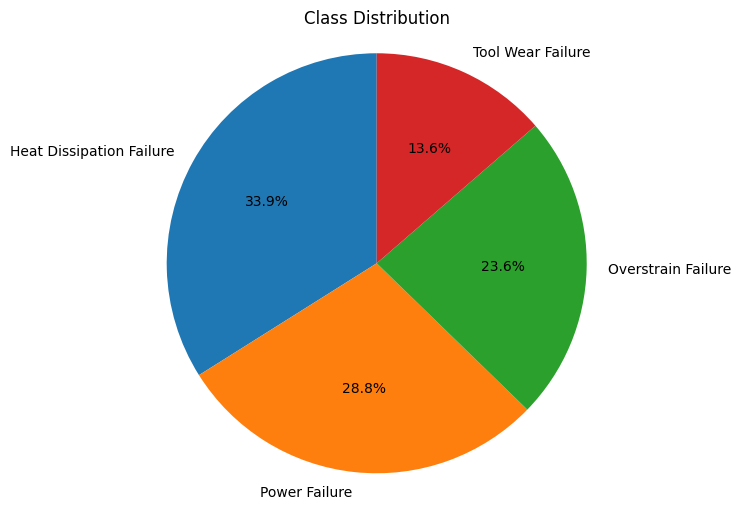

In [64]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]

# Check the resulting balance
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)

# Represents the pie chart
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Ensures that the graph is drawn as a circle
plt.title('Class Distribution')
plt.show()


There is a small significant portion of the classs “Tool Wear Failure” in compare with the others. This can turn more difficult to the model predict correctly this class without any strategic to try solve this problem. In general, all types of failure is unbalanced in relation to values with “No Failure”. Later we will analyse as we can try deal with this to soften this problem.

<Axes: >

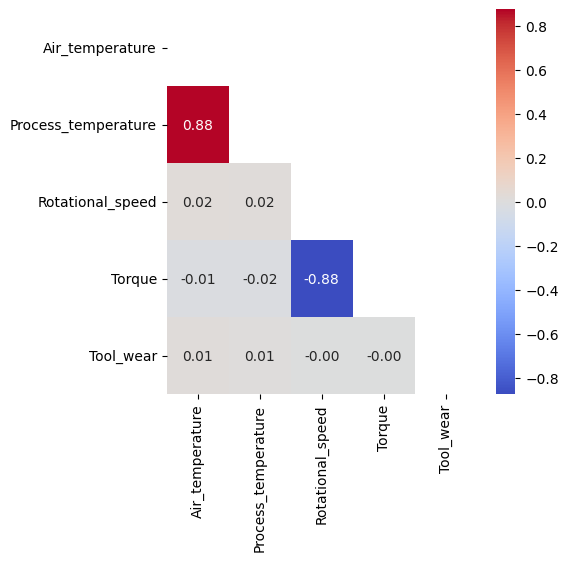

In [65]:
# Plot correlation of numeric values applying mask
corr = df.corr(numeric_only=True)
plt.figure(figsize = (5,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")


Look how wonderful! Our hypothesis of that when increase torque decrease rotational_speed is true, there is an expressive negative correlation between this features (-0.88). Futhermore, we can see now that process_temperature and air_temperature have an expressive correlation too, when air temeperature increase process temperature increase too, and this happen with the opposite.

Scaling numerical features before modeling is essential as it ensures equal contribution of all features, improves algorithm performance, especially for scale-sensitive methods, and enhances model accuracy and training efficiency.Scaling numerical features before modeling is essential as it ensures equal contribution of all features, improves algorithm performance, especially for scale-sensitive methods, and enhances model accuracy and training efficiency.

In [66]:
# Create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES
# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])
# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)
# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


PCA (Principal Component Analysis) reduces data dimensionality, highlights patterns and simplifies datasets, enhancing model performance and interpretability while preserving essential information. Lets check how much components explain more or less 95% of our data trought the graphic below.

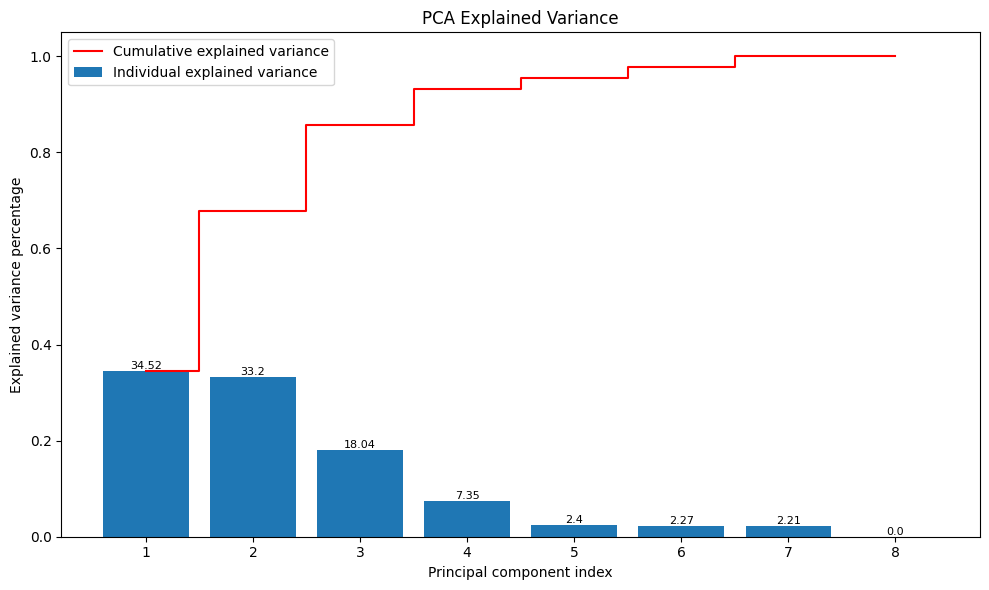

In [67]:
# Define PCA function
pca = PCA()
pca.fit(df_transformed)  # Assumindo que df_transformed é o seu DataFrame transformado

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Number of components
n_pca_components = len(exp_var)

# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2),
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

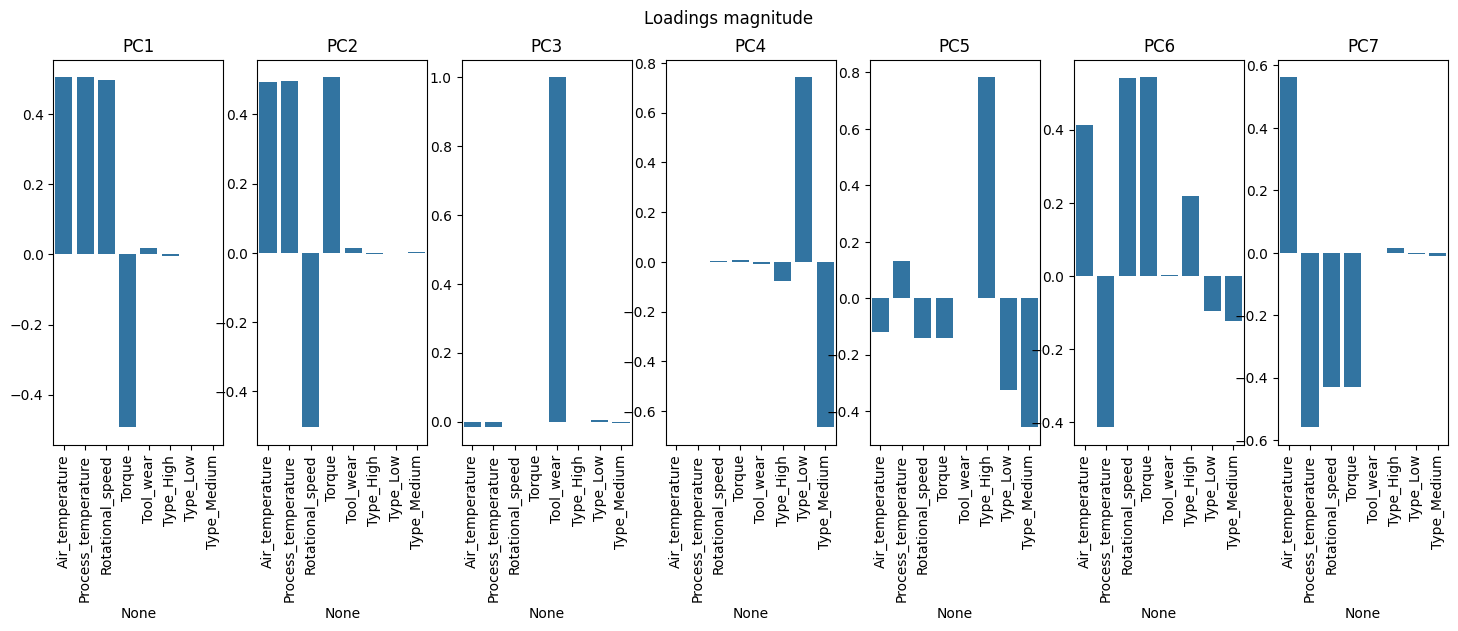

In [ ]:
# PCA with 7 components to analyse what explain each component
pca7 = PCA(n_components=7)
X_pca7 = pd.DataFrame(data=pca7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Configure of the graphics
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')

all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do
pca_loadings = pd.DataFrame(data=pca7.components_, columns=all_features)

#Plot the bar graphics
for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

PC1 and PC2: explained by Air_temperature, Process_temperatura, Rotational_speed and Torque; PC3: explained by Tool_wear; PC4: most explained by Type_Low and Type_Medium; PC5: most explained by Type_High; PC6: most explained by Air_temperature, Process_temperatura, Rotational_speed and Torque; PC7: most explained by Air_temperature, Process_temperatura, Rotational_speed and Torque.

**Create a function to get metrics**

In [70]:
from sklearn.metrics import f1_score
def get_metrics(y_true, y_pred):
    # Calculating F1 scores for each class
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)

    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

**Separate dataset in train and test**

In [71]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

**Create model with PCA and class_weight**

In [72]:
# Creating pipeline with PCA analysis and balanced class
pip_model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=4)),
    ('model', RandomForestClassifier(random_state=2023))
])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_pca.fit(X_train, y_train, model__sample_weight=weights)

# Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_pca.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.9714285714285714,
 'Balanced Accuracy': 0.32094895091539116,
 'Macro Recall': 0.32094895091539116,
 'Macro Precision': 0.5276881720430107,
 'Macro F1': 0.3667836039929063,
 'F1 Scores per Class': array([0.        , 0.98543317, 0.66666667, 0.18181818, 0.        ])}

**Create model without PCA and with class_weight**

In [73]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_pca.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.9548872180451128,
 'Balanced Accuracy': 0.8193677071112203,
 'Macro Recall': 0.8193677071112203,
 'Macro Precision': 0.5830305073735017,
 'Macro F1': 0.6539249472860765,
 'F1 Scores per Class': array([0.78571429, 0.97651095, 0.53658537, 0.80952381, 0.16129032])}

 Create model without PCA and with SMOTE-NC

In [74]:
# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES)
                                if feature in CATEGORIC_FEATURES]

# Creating the new pipeline with SMOTENC using ImbPipeline
pip_model_smotenc = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit the pipeline
pip_model_smotenc.fit(X_train, y_train)

# Generate Predictions
y_pred = pip_model_smotenc.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.9478696741854636,
 'Balanced Accuracy': 0.8551051358307641,
 'Macro Recall': 0.8551051358307641,
 'Macro Precision': 0.580598694230544,
 'Macro F1': 0.6617230015122039,
 'F1 Scores per Class': array([0.8       , 0.97241379, 0.68292683, 0.72340426, 0.12987013])}

**GridSearchCV to find better model**

GridSearchCV is a versatile tool in scikit-learn used for selecting the best machine learning model and optimizing its hyperparameters.

In [75]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Updated parameters for GridSearchCV
params = {
    'model': [
        LogisticRegressionCV(max_iter=500, random_state=2023),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        DummyClassifier()
    ],
}
# Running GridSearchCV
grid = GridSearchCV(pip_model_no_pca, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Collecting and printing the results
results = pd.DataFrame(grid.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']

# View results
print("Best model:")
print(best_model_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best model:
{'model': GradientBoostingClassifier(random_state=2023)}


**Tunnning the model**

The model has several hyperparameters to tunning but how much more hyperparameters you try tune more processing if necessary. So, to tunnning dont request a lot time to execute the tasks lets try tune only 2 hyperparameters which are one of the most convenient.

In [76]:
# New parameters for fine-tuning the RandomForestClassifier
fine_tune_params = {

    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

# Running a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(X_train, y_train)

# Collecting and printing the fine-tuned results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Print best model parameters
print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

# Finding the best estimator paramaters
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

# View new perfomance (focus on F1-score)
get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

**Confusion Matrix**

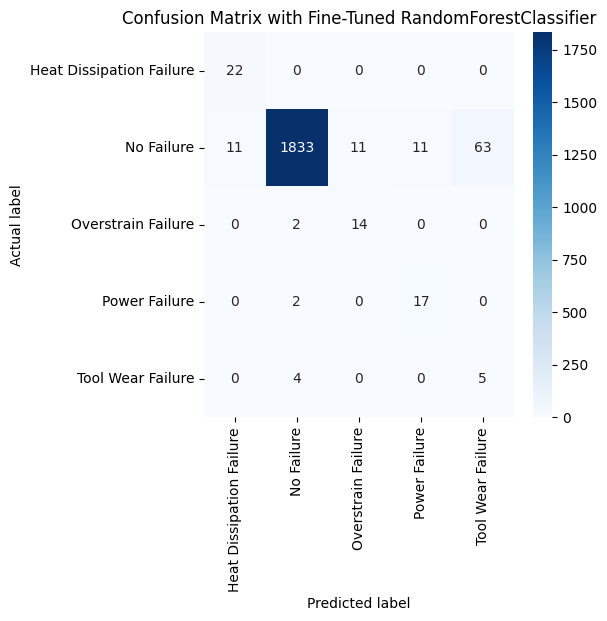

In [77]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))  # Larger figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Use 'd' to format numbers as integers
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_pred))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()

**Deployment**

In [ ]:
with open('model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)